In [28]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from flamespread import *
#reload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
exp_name ='lfs_pmma_DE_6mm_tc_R2_0001'
dewarped_data= get_dewarped_data(exp_name)


In [21]:
edge_results = get_edge_results(exp_name)

In [22]:
rolling_window = 7
edge_results_rolled = np.array(scipy.signal.medfilt(edge_results,rolling_window) ) 

In [4]:
frame_number = 1226

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: title={'center': 'Frame 1226'}>)

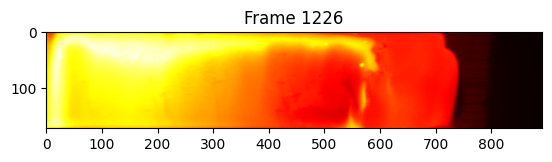

In [5]:
show_frame(dewarped_data,frame_number)


(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: title={'center': 'Flame contour at frame 1226'}>)

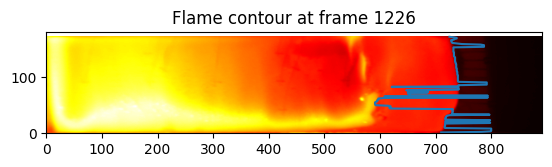

In [6]:
show_flame_contour(dewarped_data,edge_results_rolled,frame_number)


(173, 892)


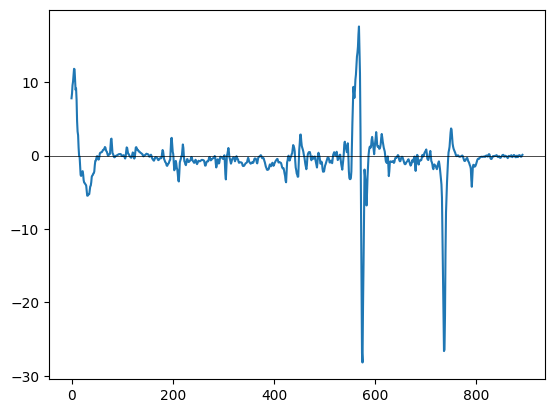

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

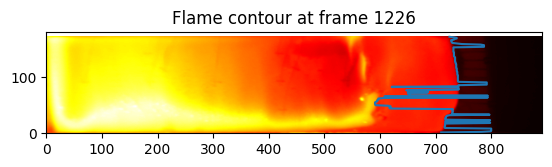

In [20]:
print(get_frame(dewarped_data,frame_number).shape)
y = 120
plot_gradient(get_frame(dewarped_data,frame_number),y)
show_flame_contour(dewarped_data,edge_results_rolled,frame_number)
plt.axhline(y=173-y, color='g', linestyle='--')
plt.show()

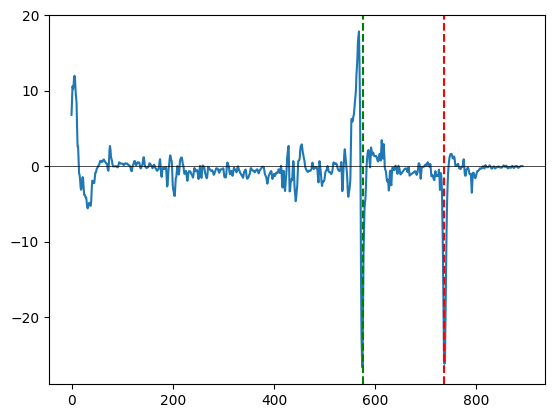

In [64]:
frame_number =1226
y = 115
y_data = get_frame(dewarped_data,frame_number)[y,:]
plot_gradient(get_frame(dewarped_data,frame_number),y)
peak = highest_peak(y_data)
plt.axvline(x=peak, color='g', linestyle='--',label='highest')
peak = highest_peak_to_lowest_value(y_data,ambient_weighting=2)
plt.axvline(x=peak, color='r', linestyle='--',label='highest to lowest')



array([ 24,  93, 135, 176, 194, 220, 283, 312, 436, 464, 501, 526, 544,
       618, 633, 693, 748, 800], dtype=int64)